In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from diagnostics import *

sns_colors = sns.color_palette()

In [2]:
# Extra parameters
folder = '../result_files/'
paramfile = '../model/svsim.param.default'
burnin = 0
second_thinning = 1

---------------------------------------
## Read the InputParam file

In [3]:
params = open(paramfile)

InputParams = {}
ThetaParams = {}            

for row in params:
    if row[:22] == 'PARAMETER START VALUES':
        break
        
    if (row[0] != '#') and not (row[:3].isupper()):
        param_type = row.split(',')[-1].strip()
        if param_type == 'char*' or param_type=='string':
            InputParams[row.split(',')[-2][1:]] = row[:12].replace(' ','')
        if param_type == 'int':
            InputParams[row.split(',')[-2][1:]] = int(row[:12].replace(' ',''))
        if param_type == 'float':
            InputParams[row.split(',')[-2][1:]] = float(row[:12].replace(' ',''))
        if param_type == 'intvec':
            var_cols = np.asarray([int(i) for i in row[:12].split(' ') if i!=''])
            InputParams[row.split(',')[-2][1:]] = var_cols
            
for row in params:
    if not (row[:3].isupper()):
        par = row.rsplit(' ', maxsplit=1)[-1].strip()
        ThetaParams[par] = [float(row.lstrip().split(' ')[0])]
        fixed = row.lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ')[0]
        number = row.lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ', maxsplit=1)[1].lstrip().split(' ')[0]
        ThetaParams[par] = ThetaParams[par] + [int(fixed)]
        ThetaParams[par] = ThetaParams[par] + [int(number)]
    else:
        break
        
for row in params:
    if not (row[:3].isupper()):
        par = row.rsplit(' ', maxsplit=1)[-1].strip()
        ThetaParams[par] = ThetaParams[par] + [float(row.lstrip().split(' ')[0])]
    else:
        break

IPF = pd.DataFrame(data=InputParams).T
IPF.columns = ['values']

summary_file = open(folder + 'figures/summary_info.dat', 'w')
title_string = """
======================================================\n
The InputParamFile used for these calculations\n
======================================================\n\n"""
summary_file.write(title_string)
summary_file.write(IPF.to_string())
summary_file.write('\n\n\n')
#summary_file.close()

IPF

,values
M,1
N,1000
ask_print,1
datafilename,svsim.dat
draw_from_prior,0
iseed,1741133992
lag_gmm,1
lag_hac,0
lag_hac_gmm,1
len_model_func,1


In [4]:
model_params = pd.DataFrame(data=ThetaParams, index=['starting_value', 'active', 'rank', 'proposal_scale']).T
model_params = model_params.reset_index()
model_params = model_params.rename(columns={"index": "params"})
model_params['rank'] = model_params['rank'].astype(int)

------------------------

## Summary

In [5]:
summary = open(folder + InputParams['project_name'] + '.summary.dat')
Summary = {}

for row in summary:
    cols = row.split()
    if cols[0] == 'param':
        for c in cols:
            Summary[c] = []
        break

for row in summary:
    if row.split() == []:
        break
    cols = row.split()
    Summary['param'] += [cols[0]]
    Summary['thetamean'] += [cols[1]]
    Summary['thetamode'] += [cols[2]]
    Summary['sehess'] += [cols[3]]
    Summary['sesand'] += [np.NaN]
    Summary['seinfo'] += [np.NaN]

#summary_file = open(folder + 'figures/summary_info.dat', 'w')

title_string = """
======================================================\n
Summary statistics for the parameters \n
======================================================\n\n"""
summary_file.write(title_string)

for row in summary:
    summary_file.write(row)
    
df_summary = pd.DataFrame(data = Summary)
df_summary = df_summary.rename(columns={'param':'rank'})
df_summary['rank'] = df_summary['rank'].astype(int)
model_params = pd.merge(model_params, df_summary[['rank', 'thetamode', 'thetamean', 'sehess']], on='rank')
model_params = model_params.sort_values(by='rank')

summary_file.write("\n")
summary_file.write(model_params.to_string())
summary_file.write('\n\n\n')

#summary_file.close()

model_params

,params,starting_value,active,rank,proposal_scale,thetamode,thetamean,sehess
2,rho,0.25,1.0,1,3.125000e-02,0.29199,0.29488,0.080489
1,phi,0.80,1.0,2,1.250000e-01,0.9415,0.41716,0.54512
3,sigma,0.10,1.0,3,1.562500e-02,0.064651,0.10443,0.057978
0,beta,1.00,0.0,4,1.192093e-07,1,1,0


-------------------------------------------
## Build rejection table

In [6]:
#============================================
# Rejection draws
#============================================

reject_draws = np.zeros((InputParams['len_model_param'] + 1, 2))

for i in range(InputParams['num_mcmc_files'] + 1):
    file = pd.read_csv(folder + InputParams['project_name'] + '.reject.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    reject_draws += np.asarray(file[2:]).reshape(dim[1], dim[0]).T[:, -2:]

second_col = np.asarray([i/reject_draws[-1,-1] 
                         for i in reject_draws[:, -1]]).reshape(InputParams['len_model_param'] + 1, 1)
first_col = []
for i in range(InputParams['len_model_param'] + 1):
    if reject_draws[i, -1] != 0.0:
        first_col.append(reject_draws[i, -2]/reject_draws[i, -1])
    else:
        first_col.append(0.0)

first_col = np.asarray(first_col).reshape(InputParams['len_model_param'] + 1, 1)        
reject_draws = np.hstack([first_col, second_col, reject_draws])

rejection_table = pd.DataFrame(data=reject_draws, columns=['rejection_rate', 'freq_move', 
                                                           'numb_rejection', 'numb_moves'])


pp = pd.concat([model_params[['rank', 'params']], 
                pd.DataFrame(data={'rank': [5, 6], 'params':['Total', '7']})]).iloc[:-1,:]
pp.reset_index()


rejection_table['rank'] = np.arange(1, InputParams['len_model_param'] + 2)
rejection_table = pd.merge(pp, rejection_table, on='rank')

rejection_table = rejection_table.set_index('params')
rejection_table = rejection_table.drop('rank', 1)
#rejection_table.to_csv(folder + 'figures/rejection_table.csv')

title_string = """
======================================================\n
Rejection table calculated from the entire sample\n
======================================================\n\n"""
summary_file.write(title_string)

#rejection_file = open(folder + 'figures/rejection_table.dat', 'w')
summary_file.write(rejection_table.to_string())
summary_file.close()

rejection_table

,rejection_rate,freq_move,numb_rejection,numb_moves
params,,,,
rho,0.126723,0.32938,2087.0,16469.0
phi,0.327086,0.33722,5515.0,16861.0
sigma,0.266347,0.33340,4440.0,16670.0
beta,0.000000,0.00000,0.0,0.0
Total,0.240840,1.00000,12042.0,50000.0


----------------------------------------
## MCMC chain of theta

In [7]:
num_draws = int(InputParams['num_mcmc_draws']*(InputParams['num_mcmc_files']+1)/InputParams['thin'])
numb_active = int(model_params['active'].sum())
list_all = list(model_params['params'])
list_active = list(model_params[model_params['active']==1]['params'])

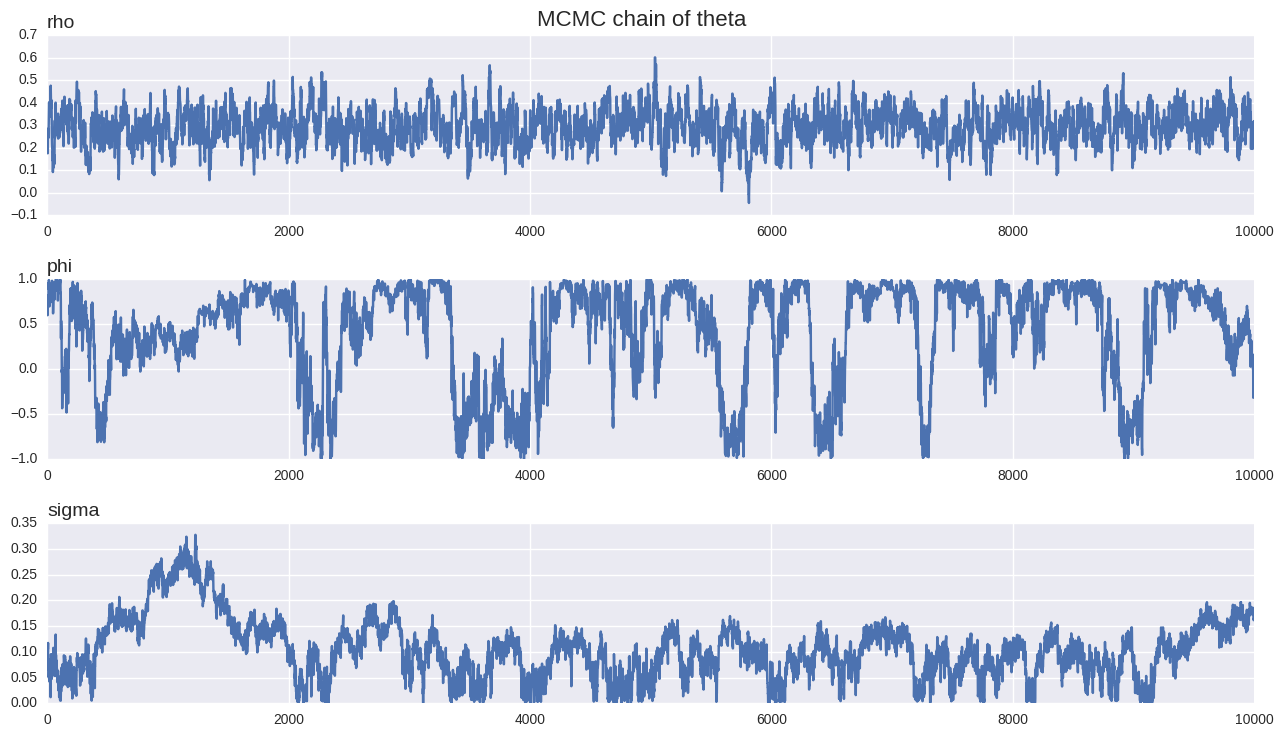

In [8]:
#============================================
# Theta draws
#============================================

theta_draws = pd.DataFrame(data =[])
theta_draws_files = []

for i in range(InputParams['num_mcmc_files'] + 1):
    file = pd.read_csv(folder + InputParams['project_name'] + '.theta.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    theta_draws_files.append(pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0])))
    theta_draws = pd.concat([theta_draws, theta_draws_files[i]], axis=0)

theta_draws.index = range(num_draws)
theta_draws.columns = list_all

fig, ax = plt.subplots(numb_active, 1, figsize=(13, 2.5*numb_active))
for i, val in enumerate(list_active):
    theta_draws.iloc[burnin::second_thinning, :][val].plot(ax=ax[i])
    ax[i].set_title(val, fontsize=14, loc='left')

#ax[0].set_ylim([0.0, .45])
#ax[1].set_ylim([.2, 1])
#ax[2].set_ylim([.04, .12])
plt.suptitle('MCMC chain of theta', fontsize=16)
plt.tight_layout()
plt.savefig(folder + 'figures/fig1.png')

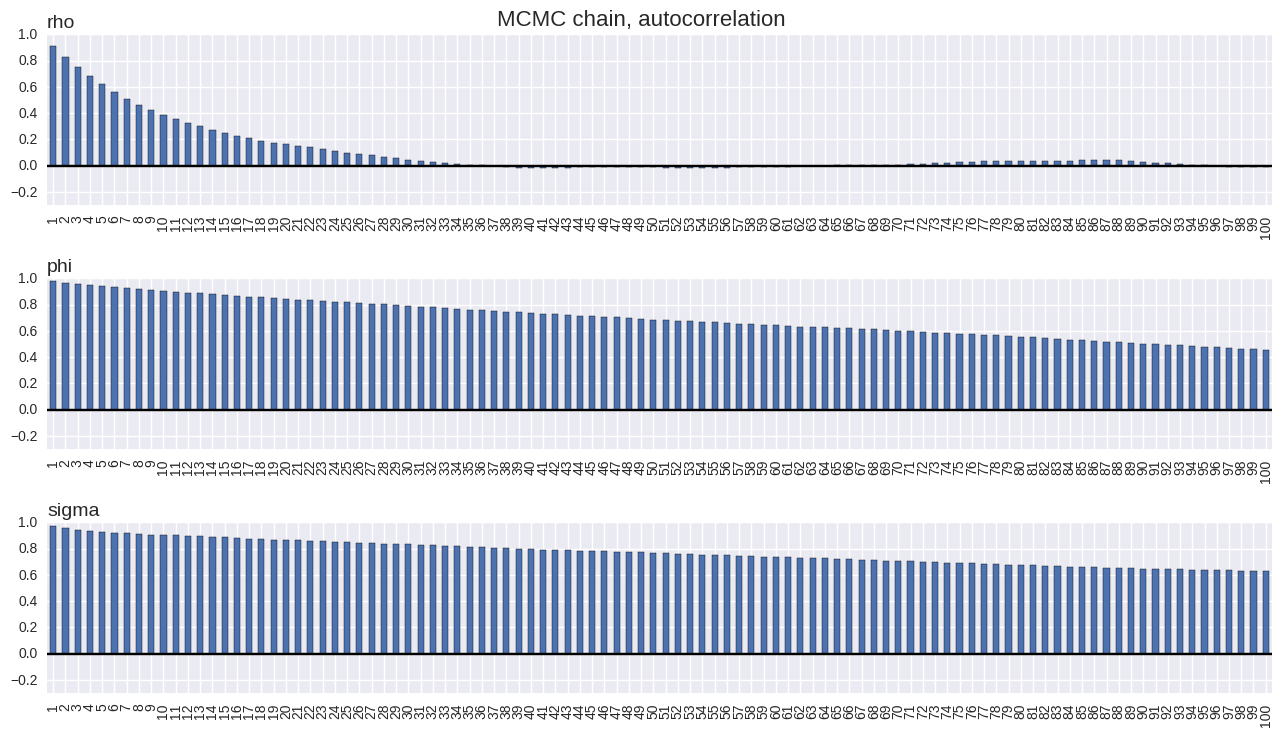

In [9]:
autocorr = np.zeros((numb_active, 100))

for i, val in enumerate(list_active):
    for lag in range(1, 101):
        autocorr[i, lag-1] = theta_draws.iloc[burnin::second_thinning, :][val].autocorr(lag=lag)
AC = pd.DataFrame(data=autocorr.T, columns=list_active, index=np.arange(1, 101))

fig, ax = plt.subplots(numb_active, 1, figsize = (13, 2.5*numb_active))
for i, val in enumerate(list_active):
    AC[val].plot(ax=ax[i], kind='bar')
    ax[i].set_title(val, fontsize=14, loc='left')
    ax[i].axhline(0, color='k')
    ax[i].set_ylim([-.3, 1])
    
fig.suptitle('MCMC chain, autocorrelation', fontsize=16)
plt.tight_layout()
plt.savefig(folder + 'figures/fig2.png')

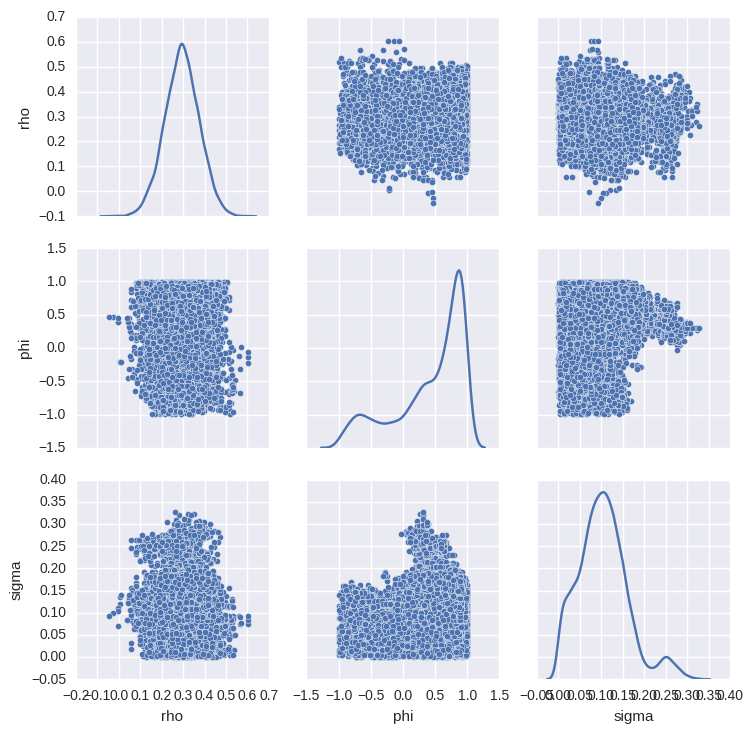

In [10]:
sns.pairplot(theta_draws.iloc[burnin::second_thinning][list_active], diag_kind='kde')
plt.savefig(folder + 'figures/fig3.png')

In [11]:
#scores = geweke(np.asarray(theta_draws.iloc[burnin::second_thinning, 1]))
#geweke_plot(scores, name='geweke', format='png', suffix='-diagnostic', path='./')

-------------------------------------
## MCMC chain for theta at times when the particle filter got updated

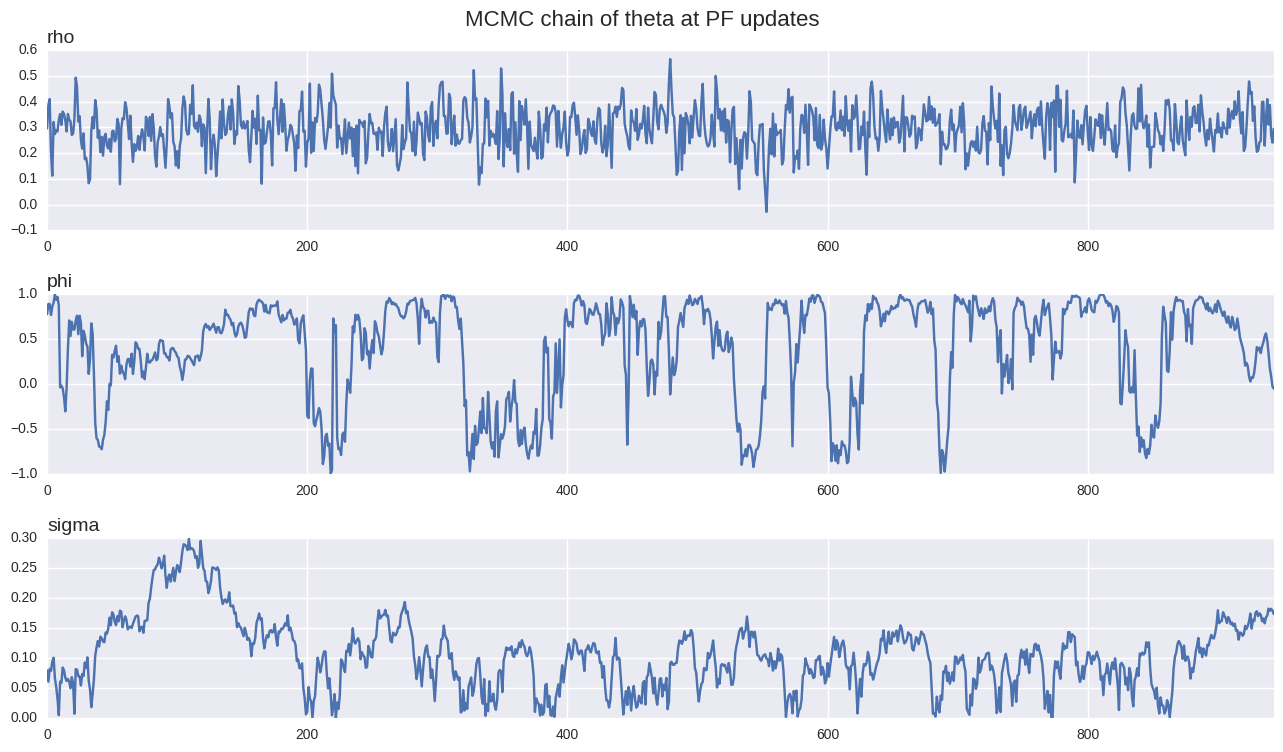

In [12]:
#============================================
# Gibbs draws
#============================================

gibbs_draws = pd.DataFrame(data =[])

for i in range(InputParams['num_mcmc_files'] + 1):
    file = pd.read_csv(folder + InputParams['project_name'] + 
                       '.usrvar.gibbs_draws.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    gibbs_draws = pd.concat([gibbs_draws, 
                                 pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0]))], axis=0)

gibbs_draws.index = range(gibbs_draws.shape[0])
gibbs_draws.columns = list_all

fig, ax = plt.subplots(numb_active, 1, figsize=(13, 2.5*numb_active))
for i, val in enumerate(list_active): 
    gibbs_draws.iloc[:, :][val].plot(ax=ax[i])
    ax[i].set_title(val, fontsize=14, loc='left')
    
plt.suptitle('MCMC chain of theta at PF updates', y=1.0, fontsize=16)
plt.tight_layout()
plt.savefig(folder + 'figures/fig4.png')

-------------------
## Posterior (and prior) values along the MCMC chain

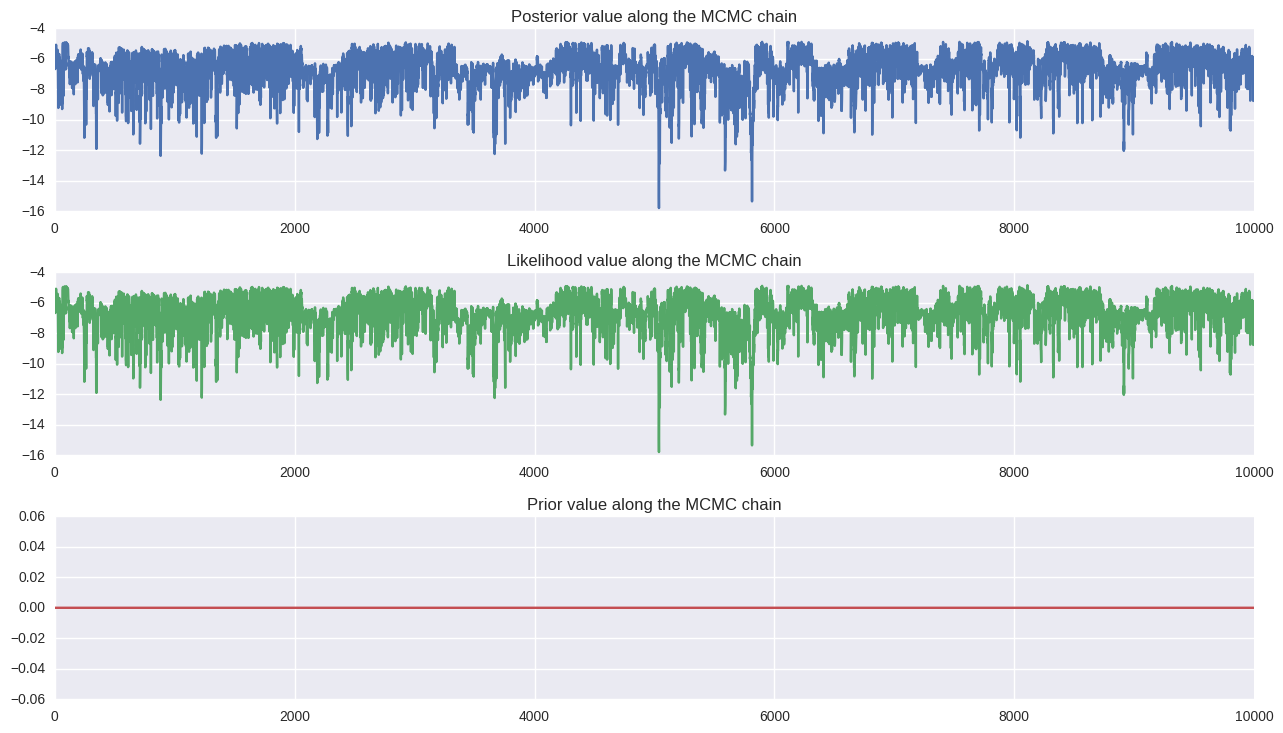

In [13]:
#============================================
# Posterior draws
#============================================

pi_draws = pd.DataFrame(data =[])

for i in range(InputParams['num_mcmc_files'] + 1):
    file = pd.read_csv(folder + InputParams['project_name'] + '.pi.00{}.dat'.format(i), header=None)
    dim = np.asarray(file[:2], dtype=int).squeeze()
    pi_draws = pd.concat([pi_draws, 
                          pd.DataFrame(data=np.asarray(file[2:]).reshape(dim[1], dim[0]))], axis=0)

pi_draws.index = range(num_draws)
pi_draws.columns = ['posterior', 'likelihood', 'prior']

fig, ax = plt.subplots(3, 1, figsize=(13, 7.5))
pi_draws.iloc[::second_thinning, 0].plot(ax=ax[0])
ax[0].set_title('Posterior value along the MCMC chain')
pi_draws.iloc[::second_thinning, 1].plot(ax=ax[1], color=[sns_colors[1]])
ax[1].set_title('Likelihood value along the MCMC chain')
pi_draws.iloc[::second_thinning, 2].plot(ax=ax[2], color=[sns_colors[2]])
ax[2].set_title('Prior value along the MCMC chain')
plt.tight_layout()
plt.savefig(folder + 'figures/fig5.png')

-------------------------------
## Particle Filter

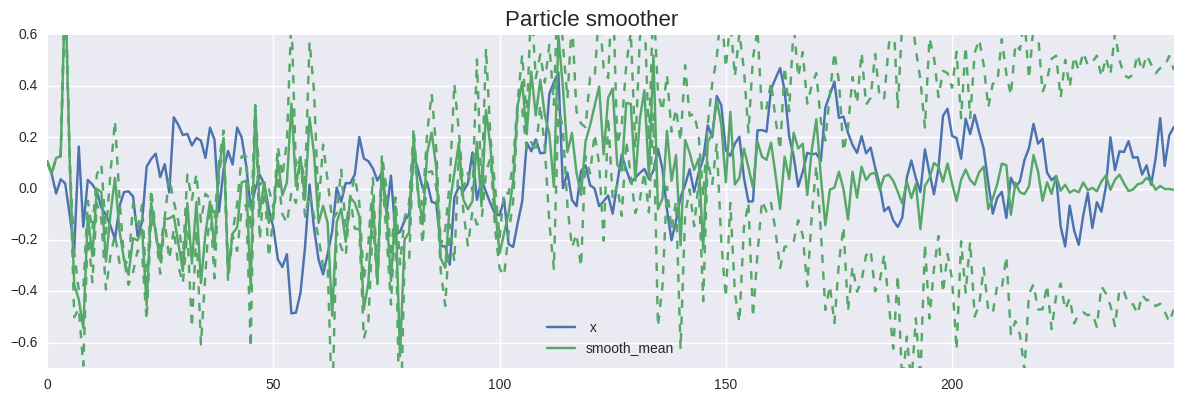

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))

particle_filter = pd.read_csv(folder + 'svsim.usrvar.filter.000.dat')
particle_filter.iloc[:, [-2, 0]].plot(ax=ax)
(particle_filter.iloc[:, 0] + 2*particle_filter.iloc[:, 1]).plot(ax=ax, linestyle='--', color=[sns_colors[1]])
(particle_filter.iloc[:, 0] - 2*particle_filter.iloc[:, 1]).plot(ax=ax, linestyle='--', color=[sns_colors[1]])
plt.suptitle('Particle smoother', fontsize=16, y=1.0)
plt.ylim([-.7, .6])
plt.tight_layout()
plt.savefig(folder + 'figures/fig6.png')

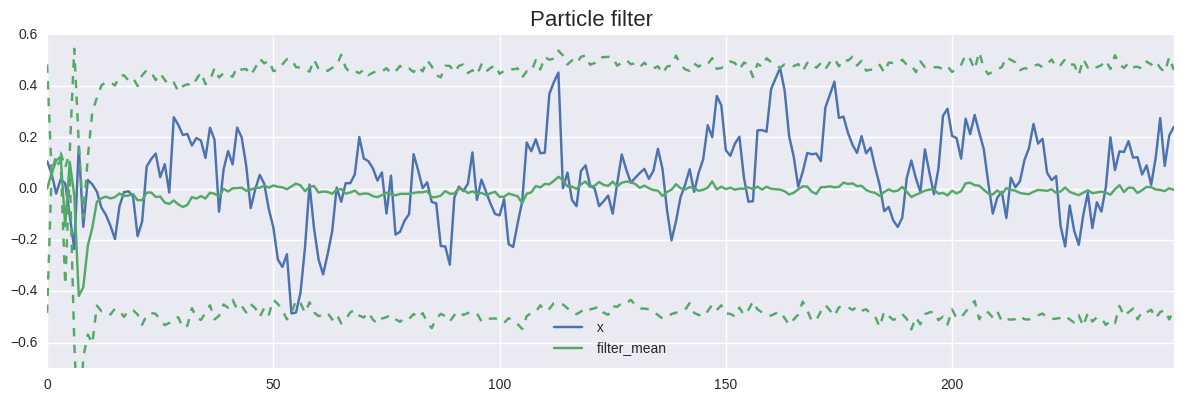

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))

particle_filter = pd.read_csv(folder + 'svsim.usrvar.filter.000.dat')
particle_filter.iloc[:, [-2, 2]].plot(ax=ax)
(particle_filter.iloc[:, 2] + 2*particle_filter.iloc[:, 3]).plot(ax=ax, linestyle='--', color=[sns_colors[1]])
(particle_filter.iloc[:, 2] - 2*particle_filter.iloc[:, 3]).plot(ax=ax, linestyle='--', color=[sns_colors[1]])
plt.suptitle('Particle filter', fontsize=16, y=1.0)
plt.ylim([-.7, .6])
plt.tight_layout()
plt.savefig(folder + 'figures/fig7.png')

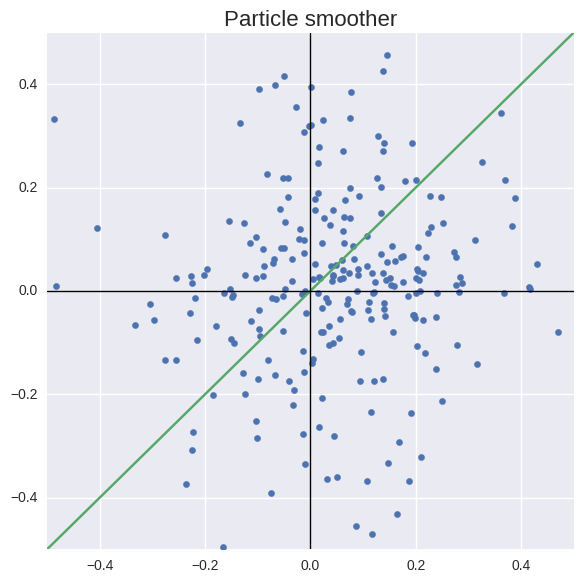

In [20]:
x = np.linspace(-.5, 0.5)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x=particle_filter.iloc[:, -2], y=particle_filter.iloc[:, 0], color=sns_colors[0])
ax.plot(x, x, color=sns_colors[1])
ax.axhline(0, color = 'k', lw=1)
ax.axvline(0, color = 'k', lw=1)
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
ax.set_title('Particle smoother', fontsize=16, y=1.0)

plt.tight_layout()
plt.savefig(folder + 'figures/fig8.png')

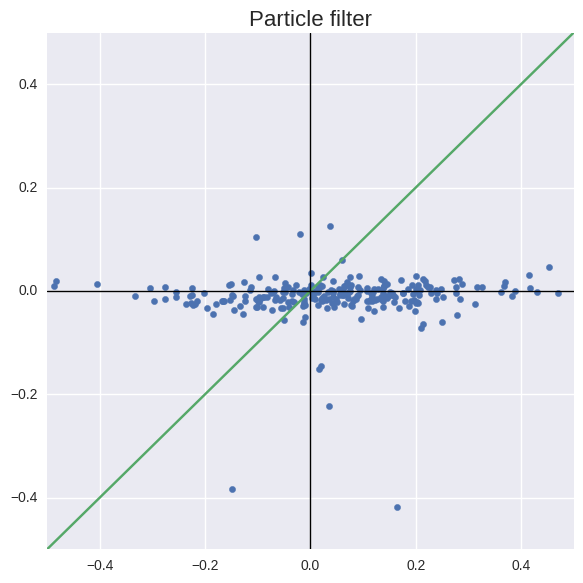

In [21]:
x = np.linspace(-.5, 0.5)

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(x=particle_filter.iloc[:, -2], y=particle_filter.iloc[:, 2], color=sns_colors[0])
ax.plot(x, x, color=sns_colors[1])
ax.axhline(0, color = 'k', lw=1)
ax.axvline(0, color = 'k', lw=1)
ax.set_xlim([-.5, .5])
ax.set_ylim([-.5, .5])
ax.set_title('Particle filter', fontsize=16, y=1.0)

plt.tight_layout()
plt.savefig(folder + 'figures/fig9.png')

--------------------------------------
## Read data

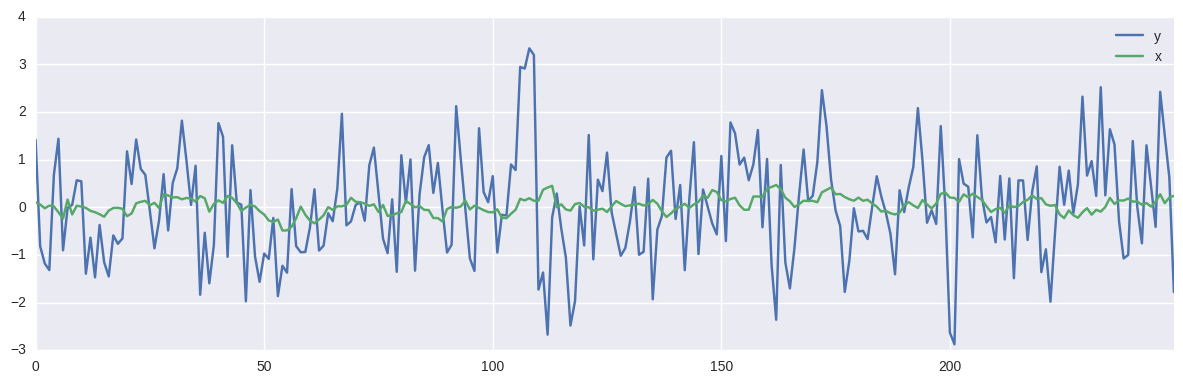

In [18]:
sample_size = InputParams['sample_size']
data = pd.read_csv('../data/svsim.dat', sep='\s+', header=None)
data.columns = ['y', 'x']
data = data[:sample_size]

fig, ax = plt.subplots(figsize=(12, 4))
data.plot(ax=ax)

plt.tight_layout()
plt.savefig(folder + 'figures/fig10.png')